In [2]:
import pandas as pd
import pandas_datareader.data as web
import requests
from io import StringIO
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import pandas_profiling

import copy

sns.set()

## References ##
* [超簡單用python抓取每月營收](https://www.finlab.tw/%E8%B6%85%E7%B0%A1%E5%96%AE%E7%94%A8python%E6%8A%93%E5%8F%96%E6%AF%8F%E6%9C%88%E7%87%9F%E6%94%B6/)
* [Python-簡單的月營收選股！](https://www.finlab.tw/Python-%E7%B0%A1%E5%96%AE%E7%94%A8%E6%9C%88%E7%87%9F%E6%94%B6%E9%81%B8%E8%82%A1%EF%BC%81/)
* [Python 簡單選股和回測](https://www.finlab.tw/Python-%E7%B0%A1%E5%96%AE%E9%81%B8%E8%82%A1%E5%92%8C%E5%9B%9E%E6%B8%AC/)
* [絕無僅有的超強指標！](https://www.finlab.tw/%E7%B5%95%E7%84%A1%E5%83%85%E6%9C%89%E7%9A%84%E8%B6%85%E5%BC%B7%E6%8C%87%E6%A8%99%EF%BC%81/)
* [優分析](https://forum.uanalyze.com.tw/forum)

## 取得近7年月盈利資料 & 結合月營收資訊 ##

In [3]:
# with open('Monthly-revenue-201412to201911.pickle', 'rb') as file:
with open('Monthly-revenue-201211to201911.pickle', 'rb') as file:
    data = pickle.load(file)
    
file.close()

for k in data.keys():
    data[k].index = data[k]['公司代號']
    
df = pd.DataFrame({k:df['當月營收'] for k, df in data.items()}).transpose()
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9940,9941,9942,9943,9944,9945,9946,9955,9958,全部國內上市公司合計
2012-11-01,2016287.0,1116753.0,94668.0,318461.0,309670.0,142214.0,171133.0,1199157.0,146586.0,2040013.0,...,626469.0,220887.0,138546.0,216083.0,22969.0,435777.0,303870.0,426869.0,415460.0,NaN
2012-12-01,1974285.0,1066478.0,112508.0,307905.0,328224.0,146031.0,165428.0,1209287.0,169246.0,2181625.0,...,855589.0,225060.0,141937.0,263918.0,23608.0,586761.0,175748.0,296301.0,421821.0,NaN
2013-01-01,9134465.0,6018213.0,288455.0,486481.0,481802.0,383780.0,179660.0,2293196.0,540783.0,7783821.0,...,794914.0,1257587.0,208732.0,286671.0,297938.0,1288950.0,519794.0,394489.0,198944.0,2.237051e+09
2013-02-01,5540346.0,2552357.0,166638.0,299860.0,276936.0,149301.0,113585.0,2065554.0,505506.0,5933139.0,...,549536.0,1035595.0,140150.0,344812.0,253338.0,991617.0,177028.0,383183.0,166364.0,1.708683e+09
2013-03-01,9457971.0,5428755.0,286007.0,461732.0,444917.0,382253.0,166981.0,2477894.0,539328.0,7306534.0,...,1210549.0,1220143.0,211044.0,246314.0,352136.0,1257334.0,771107.0,428478.0,351222.0,2.089220e+09


### 創造一個新的 dataframe 存取各上市公司基本資訊 ###

In [4]:
columns = ['Nmonthgrowth_revenue_1y','Nmonthgrowth_revenue_2y']
df_basic = pd.DataFrame(index=data['2019-11-01']['公司代號'], columns=columns)
df_basic = df_basic.fillna(0) # with 0s rather than NaNs
df_basic.index.name = 'Stock_symbol'
# df_basic.head()
# df_basic.index

avg = 6
list_Nmonthgrowth_1y = []
list_Nmonthgrowth_2y = []
list_1y_greater6m = []
list_2y_greater15m = []
for i in df_basic.index:
    method_growth = df[i].rolling(avg).mean()
    method_growth_1y = (method_growth > method_growth.shift()).iloc[-12:].sum() #計算過去一年內連續幾個月月營收皆為成長 
    method_growth_2y = (method_growth > method_growth.shift()).iloc[-24:].sum() #計算過去兩年內連續幾個月月營收皆為成長 
    list_Nmonthgrowth_1y.append(method_growth_1y)
    list_Nmonthgrowth_2y.append(method_growth_2y)
    list_1y_greater6m.append((method_growth_1y>6))
    list_2y_greater15m.append((method_growth_2y>15))
    
df_basic['Nmonthgrowth_revenue_1y'] = list_Nmonthgrowth_1y
df_basic['Nmonthgrowth_revenue_2y'] = list_Nmonthgrowth_2y
df_basic['Nmonthgrowth_revenue_1ygreater6m'] = list_1y_greater6m
df_basic['Nmonthgrowth_revenue_2ygreater15m'] = list_2y_greater15m

df_basic.drop(['全部國內上市公司合計'], inplace=True)
df_basic.head()


,Nmonthgrowth_revenue_1y,Nmonthgrowth_revenue_2y,Nmonthgrowth_revenue_1ygreater6m,Nmonthgrowth_revenue_2ygreater15m
Stock_symbol,,,,
1101,6,16,False,True
1102,6,16,False,True
1103,6,12,False,False
1104,6,13,False,False
1108,8,15,True,False


## 取得近7年股價波動率 ##

In [5]:
with open('Volatility-7y.pickle', 'rb') as file:
    list_volatility = pickle.load(file)
    
file.close()

df_basic['volatility'] = list_volatility
df_basic.head()

,Nmonthgrowth_revenue_1y,Nmonthgrowth_revenue_2y,Nmonthgrowth_revenue_1ygreater6m,Nmonthgrowth_revenue_2ygreater15m,volatility
Stock_symbol,,,,,
1101,6,16,False,True,0.014522
1102,6,16,False,True,0.013559
1103,6,12,False,False,0.012836
1104,6,13,False,False,0.012523
1108,8,15,True,False,0.010666


---
## 取得殖利率、本益比、股價淨值比等 ##
* [只用一行程式碼分析數據!?（實用的 Python Package）](https://www.finlab.tw/one-line-info-dataframe/)
* [台灣證券交易所：個股日本益比、殖利率及股價淨值比](https://www.twse.com.tw/zh/page/trading/exchange/BWIBBU_d.html)
* [一分鐘看懂本益比 – 如何找出便宜的股票?](https://rich01.com/pe-ratio-basic/)

In [6]:
with open('Dividend_yield-200809to201911.pickle', 'rb') as file:
    data_dict = pickle.load(file)

data_div_yield = copy.deepcopy(data_dict)
data_PER = copy.deepcopy(data_dict)
data_PBR = copy.deepcopy(data_dict)


for k in data_dict.keys():
    data_div_yield[k].rename(columns={'證券代號': 'Stock_symbol', '證券名稱': 'Stock_name', '殖利率(%)': 'Dividend_yield',
                  '股利年度': 'Divident_year', '本益比': 'PER', '股價淨值比': 'PBR', '財報年/季': 'Report_year_quarter'},inplace=True)
    data_div_yield[k].index = data_div_yield[k]['Stock_symbol']
    
    data_PER[k].rename(columns={'證券代號': 'Stock_symbol', '證券名稱': 'Stock_name', '殖利率(%)': 'Dividend_yield',
                  '股利年度': 'Divident_year', '本益比': 'PER', '股價淨值比': 'PBR', '財報年/季': 'Report_year_quarter'},inplace=True)
    data_PER[k].index = data_PER[k]['Stock_symbol']
    
    data_PBR[k].rename(columns={'證券代號': 'Stock_symbol', '證券名稱': 'Stock_name', '殖利率(%)': 'Dividend_yield',
                  '股利年度': 'Divident_year', '本益比': 'PER', '股價淨值比': 'PBR', '財報年/季': 'Report_year_quarter'},inplace=True)
    data_PBR[k].index = data_PBR[k]['Stock_symbol']
    data_PBR[k]['PBR'] = pd.to_numeric(data_PBR[k]['PBR'], 'coerce')
    
df_div_yield = pd.DataFrame({k:df_div_yield['Dividend_yield'] for k, df_div_yield in data_div_yield.items()}).transpose()
df_div_yield.index = pd.to_datetime(df_div_yield.index)
df_div_yield = df_div_yield.sort_index()
    
df_PER = pd.DataFrame({k:df_PER['PER'] for k, df_PER in data_PER.items()}).transpose()
df_PER.index = pd.to_datetime(df_PER.index)
df_PER = df_PER.sort_index()

df_PBR = pd.DataFrame({k:df_PBR['PBR'] for k, df_PBR in data_PBR.items()}).transpose()
df_PBR.index = pd.to_datetime(df_PBR.index)
df_PBR = df_PBR.sort_index()


### 檢查 
# df_div_yield.tail()
# df_PER.tail()
df_PBR.tail()


,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
2019-10-25,1.18,1.04,0.55,0.70,0.76,1.00,1.14,1.88,1.32,1.63,...,1.25,2.16,2.59,2.04,2.61,0.64,0.68,1.11,1.14,4.01
2019-11-01,1.17,1.03,0.56,0.70,0.76,0.98,1.14,1.92,1.33,1.61,...,1.24,2.14,2.56,2.04,2.59,0.64,0.68,1.09,1.12,4.08
2019-11-25,1.29,1.08,0.61,0.69,0.72,1.00,1.14,1.81,1.30,1.73,...,1.31,2.16,2.78,1.97,2.50,0.66,0.57,1.28,1.07,3.53
2019-12-09,1.30,1.09,0.58,0.70,0.72,0.96,1.14,1.76,1.30,1.82,...,1.32,2.14,2.69,1.97,2.53,0.66,0.56,1.28,1.09,3.43
2019-12-17,1.32,1.12,0.59,0.71,0.75,1.00,1.14,1.78,1.30,1.85,...,1.35,2.16,2.73,1.99,2.61,0.65,0.55,1.24,1.07,3.50


### 將殖利率及本益比存進新創的dataframe、做簡單的Boolean值###

In [7]:
avg = 18 # 每個月平均取3筆資料 => 半年期間約18筆資料

list_Dyield5_3y = []
list_Dyield5_3y_greater15 = []
list_Dyield5_2y_greater12 = []
list_Dyield5_1y_greater9 = []
list_Dyieldgrowth_p5y = []
list_Dyieldgrowth_1y = []
list_Dyieldgrowth_2y = []
list_Dyieldgrowth_3y = []
list_Dyieldgrowth_p5y_greater5 = []
list_Dyieldgrowth_1y_greater9 = []

list_PER15_3y = []
list_PER15_3y_greater15 = []
list_PERdrop_p5y = []
list_PERdrop_1y = []
list_PERdrop_2y = []
list_PERdrop_3y = []

for i in df_basic.index:
    if i=='6706':
        list_Dyield5_3y.append(0)
        list_PER15_3y.append(0)
        list_Dyieldgrowth_p5y.append(0)
        list_Dyieldgrowth_1y.append(0)
        list_Dyieldgrowth_2y.append(0)
        list_Dyieldgrowth_3y.append(0)
        list_Dyield5_3y_greater15.append(False)
        list_Dyield5_2y_greater12.append(False)
        list_Dyield5_1y_greater9.append(False)
        list_Dyieldgrowth_p5y_greater5.append(False)
        list_Dyieldgrowth_1y_greater9.append(False)
    
        list_PERdrop_p5y.append(0)
        list_PERdrop_1y.append(0)
        list_PERdrop_2y.append(0)
        list_PERdrop_3y.append(0)
        list_PER15_3y_greater15.append(False)
        
        continue
        
    method_Dyield = df_div_yield[i].rolling(avg).mean()
    method_PER = df_PER[i].rolling(avg).mean()
    
    list_Dyield5_3y.append(((method_Dyield>=5.).iloc[-108:].sum())/3) # 計算過去三年內有幾個月 殖利率>=5
    list_Dyield5_3y_greater15.append((((method_Dyield>=5.).iloc[-108:].sum())/3)>=15)
    list_Dyield5_2y_greater12.append((((method_Dyield>=5.).iloc[-72:].sum())/3)>=12)
    list_Dyield5_1y_greater9.append((((method_Dyield>=5.).iloc[-36:].sum())/3)>=9)
    
    list_PER15_3y.append(((method_PER<=15.).iloc[-108:].sum())/3) # 計算過去三年內有幾個月 PER(本益比)<=15
    list_PER15_3y_greater15.append((((method_PER<=15.).iloc[-108:].sum())/3)>=15)
    
    method_Dyieldgrowth_p5y = (method_Dyield > method_Dyield.shift()).iloc[-18:].sum() # 計算過去半年內有幾個月殖利率為成長
    method_Dyieldgrowth_1y = (method_Dyield > method_Dyield.shift()).iloc[-36:].sum() # 計算過去一年內
    method_Dyieldgrowth_2y = (method_Dyield > method_Dyield.shift()).iloc[-72:].sum() # 計算過去兩年內
    method_Dyieldgrowth_3y = (method_Dyield > method_Dyield.shift()).iloc[-108:].sum() # 計算過去三年內
    
    method_PERdrop_p5y = (method_PER < method_PER.shift()).iloc[-18:].sum() # 計算過去半年內 
    method_PERdrop_1y = (method_PER < method_PER.shift()).iloc[-36:].sum() # 計算過去一年內
    method_PERdrop_2y = (method_PER < method_PER.shift()).iloc[-72:].sum() # 計算過去兩年內
    method_PERdrop_3y = (method_PER < method_PER.shift()).iloc[-108:].sum() # 計算過去三年內
    
    list_Dyieldgrowth_p5y.append(method_Dyieldgrowth_p5y/3)
    list_Dyieldgrowth_1y.append(method_Dyieldgrowth_1y/3)
    list_Dyieldgrowth_2y.append(method_Dyieldgrowth_2y/3)
    list_Dyieldgrowth_3y.append(method_Dyieldgrowth_3y/3)
    list_Dyieldgrowth_p5y_greater5.append((method_Dyieldgrowth_p5y/3)>5.)
    list_Dyieldgrowth_1y_greater9.append((method_Dyieldgrowth_1y/3)>9.)
    
    list_PERdrop_p5y.append(method_PERdrop_p5y/3)
    list_PERdrop_1y.append(method_PERdrop_1y/3)
    list_PERdrop_2y.append(method_PERdrop_2y/3)
    list_PERdrop_3y.append(method_PERdrop_3y/3)
    
    
    
df_basic['Nmonth_Dyield5_3year'] = list_Dyield5_3y
df_basic['Nmonth_Dyield5_3year_greater15'] = list_Dyield5_3y_greater15
df_basic['Nmonth_Dyield5_2year_greater12'] = list_Dyield5_2y_greater12
df_basic['Nmonth_Dyield5_1year_greater9'] = list_Dyield5_1y_greater9
df_basic['Nmonthgrowth_Dyield_p5y'] = list_Dyieldgrowth_p5y
df_basic['Nmonthgrowth_Dyield_1y'] = list_Dyieldgrowth_1y
df_basic['Nmonthgrowth_Dyield_2y'] = list_Dyieldgrowth_2y
df_basic['Nmonthgrowth_Dyield_3y'] = list_Dyieldgrowth_3y
df_basic['Nmonthgrowth_Dyield_p5y_greater5'] = list_Dyieldgrowth_p5y_greater5
df_basic['Nmonthgrowth_Dyield_1y_greater9'] = list_Dyieldgrowth_1y_greater9

df_basic['Nmonth_PER15_3year'] = list_PER15_3y
df_basic['Nmonth_PER15_3year_greater15'] = list_PER15_3y_greater15
df_basic['Nmonthdrop_PER_p5y'] = list_PERdrop_p5y
df_basic['Nmonthdrop_PER_1y'] = list_PERdrop_1y
df_basic['Nmonthdrop_PER_2y'] = list_PERdrop_2y
df_basic['Nmonthdrop_PER_3y'] = list_PERdrop_3y

df_basic.head()

,Nmonthgrowth_revenue_1y,Nmonthgrowth_revenue_2y,Nmonthgrowth_revenue_1ygreater6m,Nmonthgrowth_revenue_2ygreater15m,volatility,Nmonth_Dyield5_3year,Nmonth_Dyield5_3year_greater15,Nmonth_Dyield5_2year_greater12,Nmonth_Dyield5_1year_greater9,Nmonthgrowth_Dyield_p5y,...,Nmonthgrowth_Dyield_2y,Nmonthgrowth_Dyield_3y,Nmonthgrowth_Dyield_p5y_greater5,Nmonthgrowth_Dyield_1y_greater9,Nmonth_PER15_3year,Nmonth_PER15_3year_greater15,Nmonthdrop_PER_p5y,Nmonthdrop_PER_1y,Nmonthdrop_PER_2y,Nmonthdrop_PER_3y
Stock_symbol,,,,,,,,,,,,,,,,,,,,,
1101,6,16,False,True,0.014522,15.666667,True,True,True,5.333333,...,19.000000,22.666667,True,True,10.333333,False,4.000000,10.000000,16.666667,23.000000
1102,6,16,False,True,0.013559,8.000000,False,False,False,3.666667,...,11.333333,12.666667,False,False,10.666667,False,4.000000,9.666667,20.333333,24.333333
1103,6,12,False,False,0.012836,5.000000,False,False,False,4.000000,...,18.000000,19.666667,False,False,11.333333,False,2.333333,6.000000,13.000000,17.666667
1104,6,13,False,False,0.012523,28.666667,True,True,True,1.666667,...,11.000000,15.666667,False,False,36.000000,True,4.000000,6.333333,9.000000,15.333333
1108,8,15,True,False,0.010666,22.333333,True,False,False,0.000000,...,6.333333,13.333333,False,False,12.666667,False,0.000000,0.000000,0.000000,0.000000


## 第一階段篩選 ##

In [8]:
filter1 = (df_basic['Nmonthgrowth_revenue_1ygreater6m'] == True)
filter2 = (df_basic['Nmonthgrowth_revenue_2ygreater15m'] == True)
filter3 = (df_basic['Nmonth_Dyield5_3year_greater15'] == True)
filter4 = (df_basic['Nmonth_Dyield5_2year_greater12'] == True)
filter5 = (df_basic['Nmonth_Dyield5_1year_greater9'] == True)

df_basic[(filter1 | filter2) & filter3 & filter4 & filter5].index


Index(['1101', '1210', '1229', '1233', '1464', '1615', '1773', '1817', '2006',
       '2069', '2104', '2441', '3014', '4919', '5471', '6257', '8081', '8131',
       '2356', '2376', '2397', '3005', '3515', '3706', '6277', '8114', '6136',
       '2493', '3032', '3042', '4999', '6224', '2414', '3010', '3036', '3209',
       '3528', '5434', '6189', '6281', '2480', '3029', '3130', '6112', '2433',
       '3617', '1442', '2511', '2534', '2548', '2597', '5534', '6177', '2707',
       '9943', '2812', '2820', '2838', '2850', '2851', '2855', '2867', '2884',
       '2886', '2887', '2889', '2890', '5880', '6005', '8481', '9927', '9941'],
      dtype='object', name='Stock_symbol')

## 讀取財報資訊 ##

In [65]:
### Ignore 2812, 2820, 2838, 2850, 2851, 2855, 2867, 2884, 2886, 2887, 2889, 2890, 5880, 6005
company = 1101
try:
    df_fstatement = pd.read_csv('./Financial_statement/%d.csv' %(company),index_col=0)  

    df_fstatement.index = pd.to_datetime(df_fstatement.index, format='%Y-%m-%d').year

    ### Bug fix: pct_change() does not properly deal with negative values 
    df_fstatement['淨利成長率'] = (df_fstatement['繼續營業單位稅前淨利（淨損）'] - df_fstatement['繼續營業單位稅前淨利（淨損）'].shift())/abs(df_fstatement['繼續營業單位稅前淨利（淨損）'].shift()) * 100.
    df_fstatement['營收成長率'] = (df_fstatement['營業收入合計'] - df_fstatement['營業收入合計'].shift())/abs(df_fstatement['營業收入合計'].shift()) * 100.

    col_names = ['營業收入合計','營業毛利（毛損）','營業利益（損失）',
                 '繼續營業單位稅前淨利（淨損）','營業費用合計','本期淨利（淨損）',
                 '基本每股盈餘合計','本期現金及約當現金增加（減少）數','股東權益總額',
                 '資產總額','營業毛利率(%)','營業利益率(%)','純益率(%)','股東權益率(%)',
                 '總資產報酬率(%)','營收成長率','淨利成長率']

    ### 財務報表名詞中翻英: http://twstockcurves.blogspot.com/2014/08/blog-post.html
    col_names = ['Revenue','Gross Revenue','Operating Income',
                 'Income from Continuing Operation (before tax)','Operating Expenses','Net Income',
                 'Earnings Per Share','Net Increase (decrease) In Cash and Cash Equivalents','Total Equity',
                 'Total Assets','Profit Margin (%)','Operating Profit Margin (%)','Net Profit Margin (%)','Equity Ratio (%)',
                 'Return On Total Assets (%)','Revenue Growth Rate (%)','Net Profit Growth Rate (%)']


    for iname in range(len(col_names)):
        df_fstatement.rename(columns={df_fstatement.columns[iname]: col_names[iname]}, inplace=True)

    # (df_fstatement.style.background_gradient(cmap='Blues')
    #                     .highlight_null())
    # (df_fstatement.style.background_gradient(cmap='Blues')
    #                     .bar(subset=['Revenue Growth Rate (%)'],color=['indianred','limegreen'], align='mid')
    #                     .bar(subset=['Net Profit Growth Rate (%)'],color=['indianred','limegreen'], align='mid'))
    print ('Company %d \nNo error has occured, print dataframe in the next block' %(company))
    
except Exception as e:
    print('Company %d \nErrors have occured, please check if anything is wrong' %(company))


Company 1101 
No error has occured, print dataframe in the next block


In [66]:
(df_fstatement.style.background_gradient(cmap='Blues')
                        .bar(subset=['Revenue Growth Rate (%)'],color=['indianred','limegreen'], align='mid')
                        .bar(subset=['Net Profit Growth Rate (%)'],color=['indianred','limegreen'], align='mid'))

,Revenue,Gross Revenue,Operating Income,Income from Continuing Operation (before tax),Operating Expenses,Net Income,Earnings Per Share,Net Increase (decrease) In Cash and Cash Equivalents,Total Equity,Total Assets,Profit Margin (%),Operating Profit Margin (%),Net Profit Margin (%),Equity Ratio (%),Return On Total Assets (%),Revenue Growth Rate (%),Net Profit Growth Rate (%)
2010,8.68043e+07,1.55344e+07,1.24768e+07,1.21792e+07,3.05758e+06,1.17018e+07,2.26,3.39257e+06,1.01114e+08,2.04741e+08,17.8959,14.3735,14.0307,12.0451,5.9486,nan,nan
2011,1.06207e+08,1.94963e+07,1.56543e+07,1.4951e+07,3.84202e+06,1.33957e+07,2.43,1.62807e+07,1.24528e+08,2.62071e+08,18.3569,14.7394,14.0772,12.0062,5.70495,22.3525,22.7582
2012,1.18497e+08,2.05754e+07,1.61727e+07,1.6526e+07,4.40275e+06,1.37281e+07,2.33,-1.05665e+07,1.2932e+08,2.61895e+08,17.3637,13.6482,13.9464,12.7791,6.31016,11.571,10.5342
2013,1.19455e+08,1.77091e+07,1.30734e+07,1.207e+07,4.63571e+06,9.95756e+06,2.09,3.7932e+06,1.31744e+08,2.61431e+08,14.8249,10.9442,10.1043,9.16176,4.61692,0.808788,-26.9633
2014,1.16099e+08,2.2823e+07,1.7776e+07,1.86045e+07,5.04702e+06,1.51187e+07,2.72,99659,1.53619e+08,2.82681e+08,19.6582,15.3111,16.0247,12.1108,6.58144,-2.80943,54.1375
2015,1.18326e+08,2.48726e+07,1.98577e+07,2.11987e+07,5.01493e+06,1.65839e+07,2.93,4.80298e+06,1.62018e+08,2.92744e+08,21.0204,16.7822,17.9156,13.0842,7.24139,1.91807,13.9443
2016,9.36791e+07,1.4528e+07,9.6737e+06,8.66602e+06,4.85432e+06,6.92563e+06,1.56,8.46332e+06,1.55484e+08,2.93066e+08,15.5083,10.3264,9.25075,5.57356,2.95701,-20.8295,-59.1201
2017,8.95643e+07,1.7981e+07,1.30341e+07,1.15153e+07,4.94687e+06,8.84208e+06,1.72,-1.07976e+07,1.47397e+08,2.66989e+08,20.0761,14.5528,12.8571,7.81248,4.31304,-4.39241,32.8792
2018,9.83118e+07,1.89129e+07,1.39629e+07,1.38247e+07,4.95003e+06,1.03228e+07,2.03,-1.84854e+06,1.52647e+08,2.72557e+08,19.2377,14.2027,14.0621,9.05661,5.07221,9.76669,20.0543
2019,1.24595e+08,3.35915e+07,2.81809e+07,3.05444e+07,5.41064e+06,2.26441e+07,4.37,2.21767e+07,1.97379e+08,3.44085e+08,26.9607,22.6181,24.515,15.475,8.877,26.7342,120.942


In [112]:
### 獲利性分析
### 1. ROE長期 > 15% （近1年數據 > 15% 與近5年平均ROE > 15%）
### ROE = Return On Equity  
###     = Equity Ratio (%) 股東權益報酬率、股東權益率
### 2. 淨利率(純益率 Net Profit Margin)長期 > 10% (近1年數據 > 10% , 近5年平均 > 10%)
print ('獲利性分析:')
print (' 近1年股東權益率(%) =', df_fstatement['Equity Ratio (%)'].iloc[-1:].values[0], 
       '; >15% ? =>', (df_fstatement['Equity Ratio (%)'].iloc[-1:].values[0] >= 15.))
print (' 近5年平均股東權益率(%) =',df_fstatement['Equity Ratio (%)'].iloc[-5:].mean(),
       '; >15% ? =>', (df_fstatement['Equity Ratio (%)'].iloc[-5:].mean() >= 15.))
print (' 近1年淨利率(%) =', df_fstatement['Net Profit Margin (%)'].iloc[-1:].values[0], 
       ' ; >15% ? =>',(df_fstatement['Net Profit Margin (%)'].iloc[-1:].values[0] >= 15.))
print (' 近5年平均淨利率(%) =',df_fstatement['Net Profit Margin (%)'].iloc[-5:].mean(),
       '; >15% ? =>', (df_fstatement['Net Profit Margin (%)'].iloc[-5:].mean() >= 15.))

### 安全性分析
### 3. 營業現金流對淨利比 > 50% （近一年數據 > 50%, 近5年平均 > 50%）
### 4. 自由現金流長期 > 0 （近一年數據 > 0, 近5年平均 > 0）
###    自由現金流在此取 “本期現金及約當現金增加（減少）數”
print ('安全性分析:')
print (' 近1年本期現金及約當現金增加（減少）數 (千元) =', df_fstatement['Net Increase (decrease) In Cash and Cash Equivalents'].iloc[-1:].values[0], 
       ' ; >0 ? =>',(df_fstatement['Net Increase (decrease) In Cash and Cash Equivalents'].iloc[-1:].values[0] >= 0.))
print (' 近5年平均本期現金及約當現金增加（減少）數 (千元) =',df_fstatement['Net Increase (decrease) In Cash and Cash Equivalents'].iloc[-5:].mean(),
       '; >0 ? =>', (df_fstatement['Net Increase (decrease) In Cash and Cash Equivalents'].iloc[-5:].mean() >= 15.))

print ('價值評估:')
print ('成長性分析:')
# df_fstatement['Equity Ratio (%)'].iloc[-5:].mean()

獲利性分析:
 近1年股東權益率(%) = 15.474974761304438 ; >15% ? => True
 近5年平均股東權益率(%) = 10.200365573803092 ; >15% ? => False
 近1年淨利率(%) = 24.515043597153593  ; >15% ? => True
 近5年平均淨利率(%) = 15.72009161418615 ; >15% ? => True
安全性分析:
 近1年本期現金及約當現金增加（減少）數 (千元) = 22176671.0  ; >0 ? => True
 近5年平均本期現金及約當現金增加（減少）數 (千元) = 4559364.8 ; >0 ? => True
價值評估:
成長性分析:


## 財報分析資料 ##

In [15]:
### 2012年後的財務分析資料無 “獲利能力-營業利益佔實收資本比率(%)” 此欄位

def fstatement_analysis(stock_symbol):
    df = pd.DataFrame()

    for y in range(2018,2008,-1):
        df_tmp = pd.read_csv('./Financial-analysis-report/%d.csv' %(y))
        # df_tmp['年份'] = y
        # df_tmp.set_index('年份',inplace=True, drop=True)
        df_tmp = df_tmp.loc[df_tmp['公司代號'] == stock_symbol]
        if y<=2012:
            df_tmp.rename(columns={'財務結構-長期資金佔固定資產比率(%)':'財務結構-長期資金佔不動產、廠房及設備比率(%)'}, inplace=True)
            df_tmp.rename(columns={'經營能力->應收款項收現日數':'經營能力-平均收現日數'}, inplace=True)
            df_tmp.rename(columns={'經營能力-固定資產週轉率(次)':'經營能力-不動產、廠房及設備週轉率(次)'}, inplace=True)
            df_tmp.rename(columns={'獲利能力-股東權益報酬率(%)':'獲利能力-權益報酬率(%)'}, inplace=True)

        df_tmp = df_tmp.T

        df['%d'%(y)] = df_tmp[df_tmp.columns[0]]

    df = df.T
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], 'coerce')

    df.drop(['公司代號', '公司簡稱'], axis=1, inplace=True)
    df.rename(columns={'現金流量-現金再投<br>資比率(%)':'現金流量-現金再投資比率(%)'}, inplace=True)
    df.index = pd.to_datetime(df.index)  
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d').year
    df = df.sort_index()
    
    return df

df_fstatement_analysis = fstatement_analysis(company)

(df_fstatement_analysis.style.background_gradient(cmap='Blues')
                    .highlight_null())


,財務結構-負債佔資產比率(%),財務結構-長期資金佔不動產、廠房及設備比率(%),償債能力-流動比率(%),償債能力-速動比率(%),償債能力-利息保障倍數(%),經營能力-應收款項週轉率(次),經營能力-平均收現日數,經營能力-存貨週轉率(次),經營能力-平均售貨日數,經營能力-不動產、廠房及設備週轉率(次),經營能力-總資產週轉率(次),獲利能力-資產報酬率(%),獲利能力-權益報酬率(%),獲利能力-稅前純益佔實收資本比率(%),獲利能力-純益率(%),獲利能力-每股盈餘(元),現金流量-現金流量比率(%),現金流量-現金流量允當比率(%),現金流量-現金再投資比率(%)
2009,33.33,459.47,147.11,84.87,34.2,8.47,43.09,10.31,35.4,8.47,1.42,8.46,12.59,30.17,5.67,2.63,45.66,122.04,6.62
2010,37.08,423.83,123.86,71.24,31.59,8.83,41.33,9.27,39.37,7.86,1.33,7.38,11.1,24.52,5.14,2.36,17.28,50.35,1.28
2011,37.91,405.06,104.73,63.1,23.87,9.15,39.89,9.46,38.58,7.82,1.32,6.65,10.27,22.42,4.64,2.22,10.72,45.87,0
2012,38.63,393.81,107.88,67.52,13.68,8.91,40.96,9.36,38.99,7.53,1.28,4.4,6.61,15.19,3.11,1.43,11.86,57.34,0.53
2013,51.15,198.67,141.61,79.33,12.78,16.1,22.67,9.55,38.21,8.01,2.47,6.61,12.64,45.78,2.49,3.42,30,157.62,17.9
2014,51.82,186.83,136.03,76.94,6.42,15.97,22.85,9.69,37.66,7.28,2.3,2.99,5.16,20.26,1.09,1.7,14.98,80.19,8.24
2015,51.91,190.32,123.09,73.88,4.41,8.48,43.04,8.56,42.64,6.12,1.92,1.64,2.48,13.15,0.62,0.87,18.7,116.7,11.96
2016,46.7,184.89,123.35,70.26,9.65,8.07,45.22,8.56,42.64,6.3,1.95,7.27,13,42.65,3.38,3.01,25.08,179.36,18.32
2017,46.69,184.22,131.49,75.7,12.05,7.75,47.09,8.24,44.29,6,1.93,7.33,12.66,45.35,3.49,3.28,28.29,109.79,15.82
2018,47.74,177.82,125.42,68,9.83,11.8,30.93,7.18,50.83,5.19,1.74,6.41,10.98,38.47,3.33,2.75,11.37,93.37,2.38


---
## 畫圖 ##

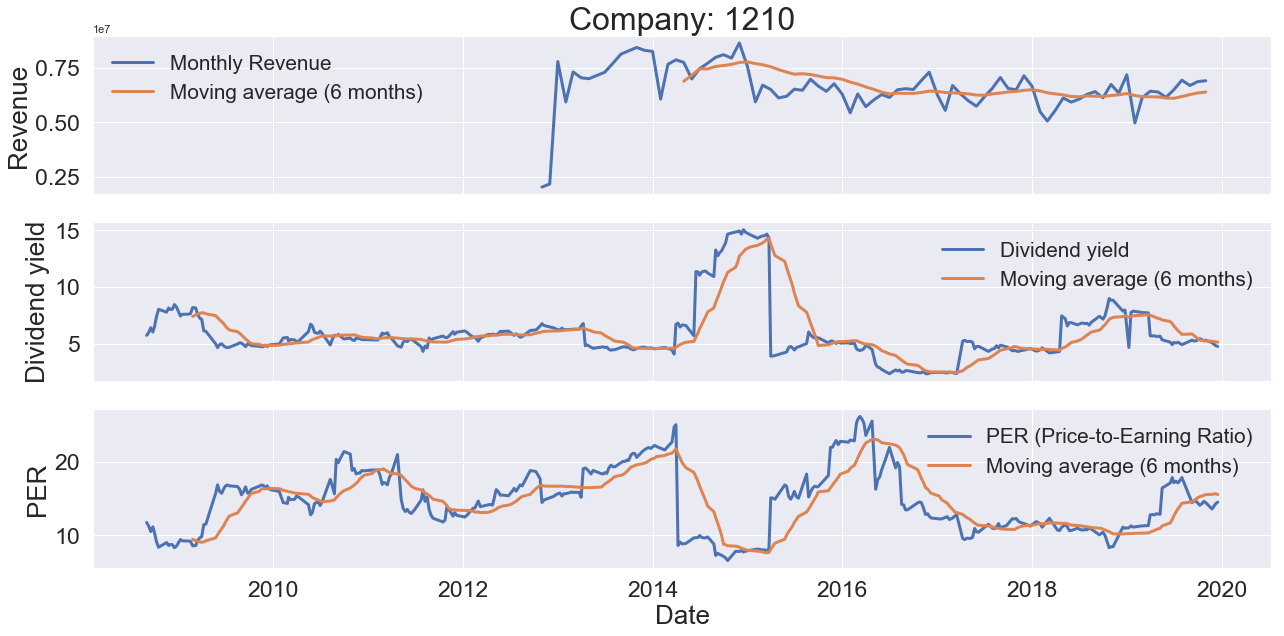

In [285]:
# company = '6277'
avg = 18 # 每個月平均取3筆資料 => 半年期間約18筆資料

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(18, 9), 
                       sharex='col')

# fig = plt.figure(figsize=(18,9))
# ax1 = fig.add_subplot(311)
# ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)

ax1.plot(df[company].index, df[company], label='Monthly Revenue', linewidth=3)
# ax1.bar(df[company].index, df[company], label='Monthly Revenue')
ax1.plot(df[company].index, df[company].rolling(avg).mean(), label='Moving average (%d months)' %(avg/3), linewidth=3)
# ax1.set_xlabel('Date',fontsize=21)
ax1.set_ylabel('Revenue', fontsize=26)
ax1.tick_params(axis='x', labelsize=23)
ax1.tick_params(axis='y', labelsize=23)
ax1.legend(loc='best',fontsize='xx-large')
ax1.set_title('Company: '+company,fontsize = 32)

ax2.plot(df_div_yield[company].index, df_div_yield[company], label='Dividend yield', linewidth=3)
ax2.plot(df_div_yield[company].index, df_div_yield[company].rolling(avg).mean(), label='Moving average (%d months)' %(avg/3), linewidth=3)
# ax2.set_xlabel('Date',fontsize=26)
ax2.set_ylabel('Dividend yield', fontsize=26)
ax2.tick_params(axis='x', labelsize=23)
ax2.tick_params(axis='y', labelsize=23)
ax2.legend(loc='best',fontsize='xx-large')

ax3.plot(df_PER[company].index, df_PER[company], label='PER (Price-to-Earning Ratio)', linewidth=3)
ax3.plot(df_PER[company].index, df_PER[company].rolling(avg).mean(), label='Moving average (%d months)' %(avg/3), linewidth=3)
ax3.set_xlabel('Date',fontsize=26)
ax3.set_ylabel('PER', fontsize=26)
ax3.tick_params(axis='x', labelsize=23)
ax3.tick_params(axis='y', labelsize=23)
ax3.legend(loc='best',fontsize='xx-large')

# ax3.plot(df_PBR[company].index, df_PBR[company], label='PBR (Price-Book Ratio)', linewidth=2.5)
# ax3.plot(df_PBR[company].index, df_PBR[company].rolling(avg).mean(), label='Moving average (%d months)' %(avg), linewidth=3)
# ax3.set_xlabel('Date',fontsize=26)
# ax3.set_ylabel('PBR', fontsize=26)
# ax3.tick_params(axis='x', labelsize=23)
# ax3.tick_params(axis='y', labelsize=23)
# ax3.legend(loc='best',fontsize='xx-large')
# ax3.set_title('PBR (Price-Book Ratio)',fontsize = 35)

plt.tight_layout()


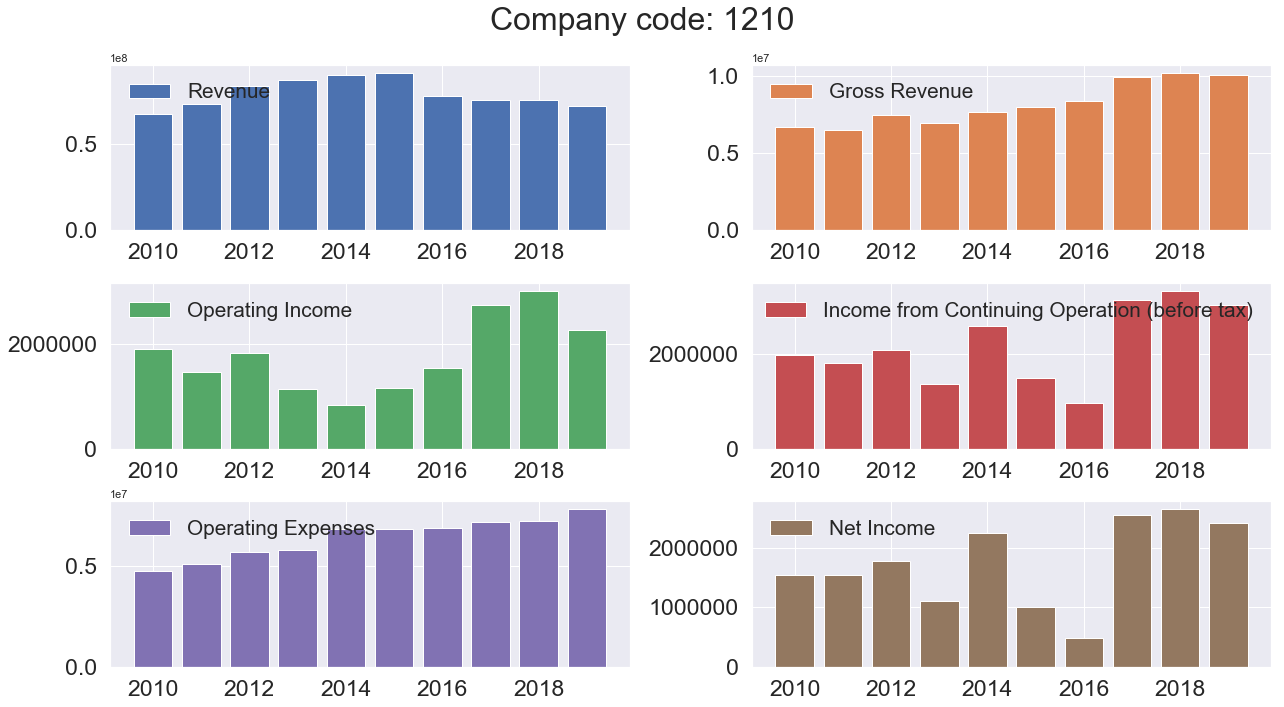

In [281]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

fig.suptitle('Company code: '+company,fontsize = 32)

ax1.bar(df_fstatement.index, df_fstatement['Revenue'], label='Revenue',color='C0')
# ax1.set_ylabel('Revenue', fontsize=26)
ax1.tick_params(axis='x', labelsize=23)
ax1.tick_params(axis='y', labelsize=23)
ax1.legend(loc='best',fontsize='xx-large')
# ax1.set_title('Company: '+company,fontsize = 32)

ax2.bar(df_fstatement.index, df_fstatement['Gross Revenue'], label='Gross Revenue',color='C1')
# ax2.set_ylabel('Gross Revenue', fontsize=26)
ax2.tick_params(axis='x', labelsize=23)
ax2.tick_params(axis='y', labelsize=23)
ax2.legend(loc='best',fontsize='xx-large')

ax3.bar(df_fstatement.index, df_fstatement['Operating Income'], label='Operating Income',color='C2')
# ax3.set_ylabel('Operating Income', fontsize=26)
ax3.tick_params(axis='x', labelsize=23)
ax3.tick_params(axis='y', labelsize=23)
ax3.legend(loc='best',fontsize='xx-large')

ax4.bar(df_fstatement.index, df_fstatement['Income from Continuing Operation (before tax)'], 
         label='Income from Continuing Operation (before tax)',color='C3')
# ax4.set_ylabel('Income from Continuing Operation (before tax)', fontsize=26)
ax4.tick_params(axis='x', labelsize=23)
ax4.tick_params(axis='y', labelsize=23)
ax4.legend(loc='best',fontsize='xx-large')

ax5.bar(df_fstatement.index, df_fstatement['Operating Expenses'], label='Operating Expenses',color='C4')
# ax5.set_ylabel('Operating Expenses', fontsize=26)
ax5.tick_params(axis='x', labelsize=23)
ax5.tick_params(axis='y', labelsize=23)
ax5.legend(loc='best',fontsize='xx-large')

ax6.bar(df_fstatement.index, df_fstatement['Net Income'], label='Net Income',color='C5')
# ax6.set_ylabel('Net Income', fontsize=26)
ax6.tick_params(axis='x', labelsize=23)
ax6.tick_params(axis='y', labelsize=23)
ax6.legend(loc='best',fontsize='xx-large')

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# df_fstatement['Profit Margin (%)'].plot(kind='bar')
# plt.ylabel('Profit Margin (%)')

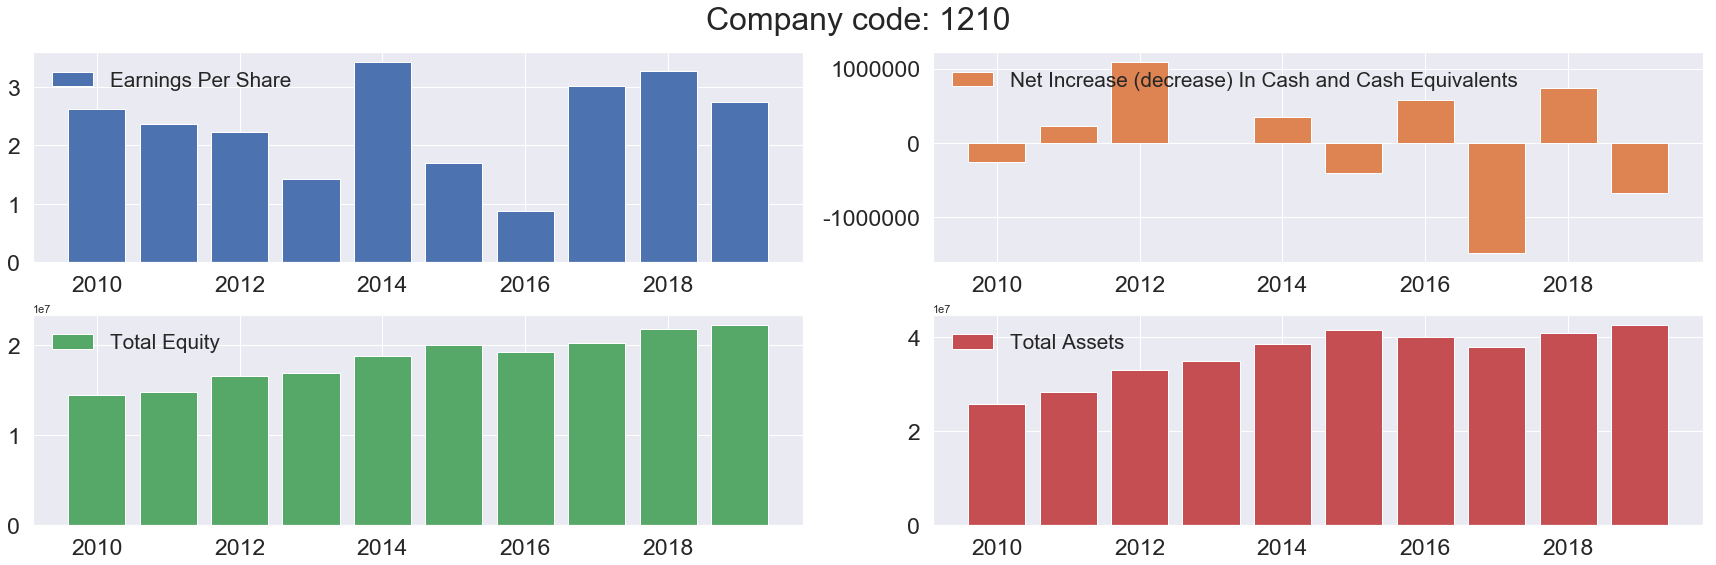

In [282]:
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

fig.suptitle('Company code: '+company,fontsize = 32)

ax1.bar(df_fstatement.index, df_fstatement['Earnings Per Share'], label='Earnings Per Share',color='C0')
# ax1.set_ylabel('Revenue', fontsize=26)
ax1.tick_params(axis='x', labelsize=23)
ax1.tick_params(axis='y', labelsize=23)
ax1.legend(loc='best',fontsize='xx-large')
# ax1.set_title('Company: '+company,fontsize = 32)

ax2.bar(df_fstatement.index, df_fstatement['Net Increase (decrease) In Cash and Cash Equivalents'], 
        label='Net Increase (decrease) In Cash and Cash Equivalents',color='C1')
# ax2.set_ylabel('Gross Revenue', fontsize=26)
ax2.tick_params(axis='x', labelsize=23)
ax2.tick_params(axis='y', labelsize=23)
ax2.legend(loc='best',fontsize='xx-large')

ax3.bar(df_fstatement.index, df_fstatement['Total Equity'], label='Total Equity',color='C2')
# ax3.set_ylabel('Operating Income', fontsize=26)
ax3.tick_params(axis='x', labelsize=23)
ax3.tick_params(axis='y', labelsize=23)
ax3.legend(loc='best',fontsize='xx-large')

ax4.bar(df_fstatement.index, df_fstatement['Total Assets'], 
         label='Total Assets',color='C3')
# ax4.set_ylabel('Income from Continuing Operation (before tax)', fontsize=26)
ax4.tick_params(axis='x', labelsize=23)
ax4.tick_params(axis='y', labelsize=23)
ax4.legend(loc='best',fontsize='xx-large')

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# df_fstatement['Profit Margin (%)'].plot(kind='bar')
# plt.ylabel('Profit Margin (%)')

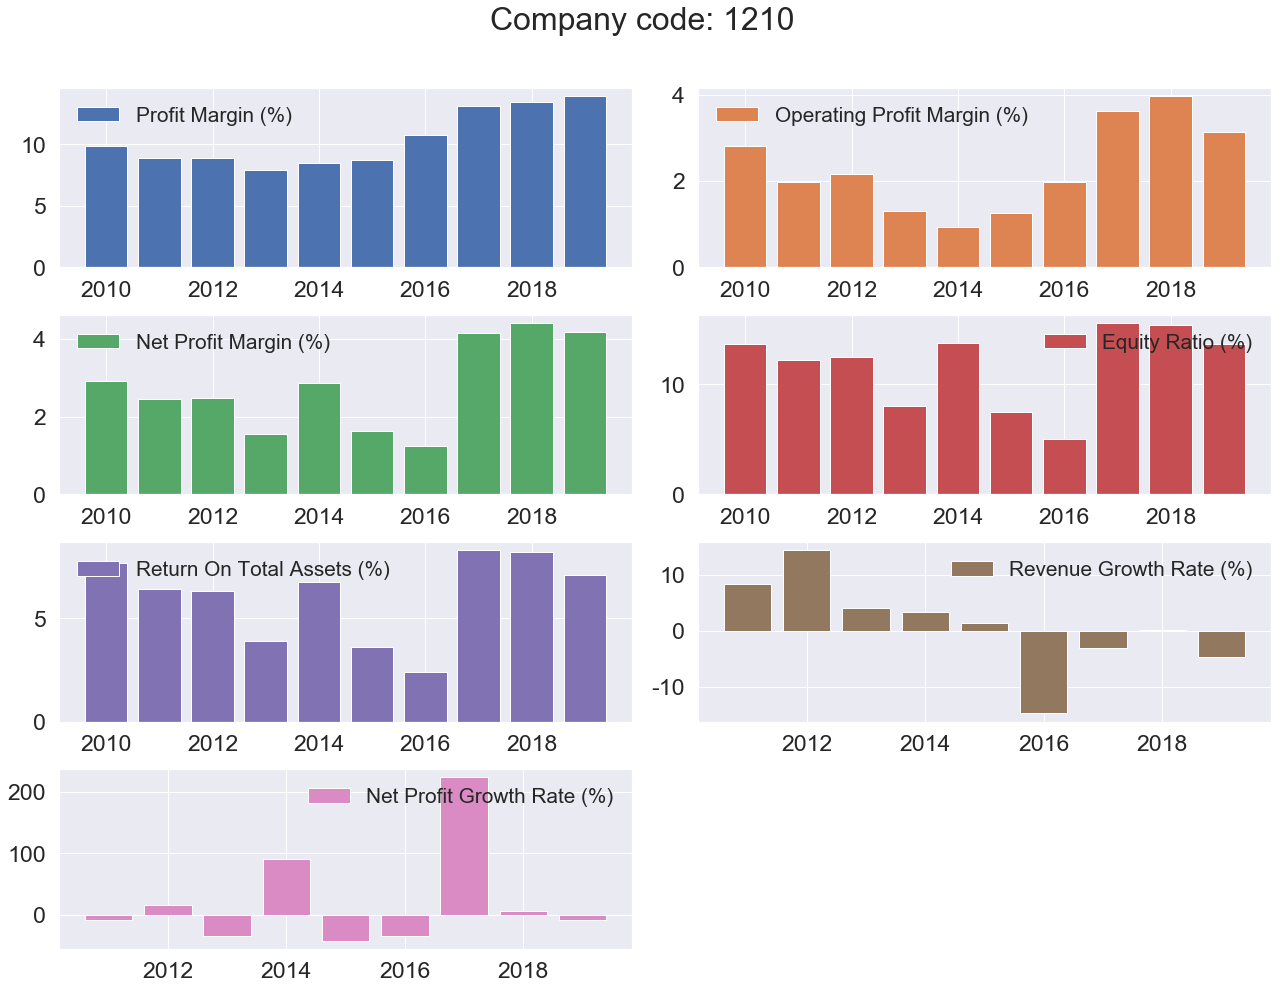

In [283]:
fig = plt.figure(figsize=(18,14))
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
# ax8 = fig.add_subplot(428)

fig.suptitle('Company code: '+company,fontsize = 32)

ax1.bar(df_fstatement.index, df_fstatement['Profit Margin (%)'], label='Profit Margin (%)',color='C0')
# ax1.set_ylabel('Revenue', fontsize=26)
ax1.tick_params(axis='x', labelsize=23)
ax1.tick_params(axis='y', labelsize=23)
ax1.legend(loc='best',fontsize='xx-large')
# ax1.set_title('Company: '+company,fontsize = 32)

ax2.bar(df_fstatement.index, df_fstatement['Operating Profit Margin (%)'], label='Operating Profit Margin (%)',color='C1')
# ax2.set_ylabel('Gross Revenue', fontsize=26)
ax2.tick_params(axis='x', labelsize=23)
ax2.tick_params(axis='y', labelsize=23)
ax2.legend(loc='best',fontsize='xx-large')

ax3.bar(df_fstatement.index, df_fstatement['Net Profit Margin (%)'], label='Net Profit Margin (%)',color='C2')
# ax3.set_ylabel('Operating Income', fontsize=26)
ax3.tick_params(axis='x', labelsize=23)
ax3.tick_params(axis='y', labelsize=23)
ax3.legend(loc='best',fontsize='xx-large')

ax4.bar(df_fstatement.index, df_fstatement['Equity Ratio (%)'], 
         label='Equity Ratio (%)',color='C3')
# ax4.set_ylabel('Income from Continuing Operation (before tax)', fontsize=26)
ax4.tick_params(axis='x', labelsize=23)
ax4.tick_params(axis='y', labelsize=23)
ax4.legend(loc='best',fontsize='xx-large')

ax5.bar(df_fstatement.index, df_fstatement['Return On Total Assets (%)'], label='Return On Total Assets (%)',color='C4')
# ax5.set_ylabel('Operating Expenses', fontsize=26)
ax5.tick_params(axis='x', labelsize=23)
ax5.tick_params(axis='y', labelsize=23)
ax5.legend(loc='best',fontsize='xx-large')

ax6.bar(df_fstatement.index, df_fstatement['Revenue Growth Rate (%)'], label='Revenue Growth Rate (%)',color='C5')
# ax6.set_ylabel('Net Income', fontsize=26)
ax6.tick_params(axis='x', labelsize=23)
ax6.tick_params(axis='y', labelsize=23)
ax6.legend(loc='best',fontsize='xx-large')

ax7.bar(df_fstatement.index, df_fstatement['Net Profit Growth Rate (%)'], label='Net Profit Growth Rate (%)',color='C6')
# ax6.set_ylabel('Net Income', fontsize=26)
ax7.tick_params(axis='x', labelsize=23)
ax7.tick_params(axis='y', labelsize=23)
ax7.legend(loc='best',fontsize='xx-large')

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# df_fstatement['Profit Margin (%)'].plot(kind='bar')
# plt.ylabel('Profit Margin (%)')

### Obsolete ###

In [284]:
### one simple way to visualize correlation matrix from dataframe
corr = df_fstatement.corr()
corr.style.background_gradient(cmap='coolwarm')

,Revenue,Gross Revenue,Operating Income,Income from Continuing Operation (before tax),Operating Expenses,Net Income,Earnings Per Share,Net Increase (decrease) In Cash and Cash Equivalents,Total Equity,Total Assets,Profit Margin (%),Operating Profit Margin (%),Net Profit Margin (%),Equity Ratio (%),Return On Total Assets (%),Revenue Growth Rate (%),Net Profit Growth Rate (%)
Revenue,1,-0.202513,-0.641912,-0.307063,0.168303,-0.267118,-0.234258,0.222497,0.123524,0.381311,-0.590028,-0.743614,-0.504639,-0.426339,-0.52029,0.304123,-0.147677
Gross Revenue,-0.202513,1,0.747716,0.702845,0.882742,0.591162,0.362087,-0.318478,0.917097,0.758891,0.909282,0.69625,0.697843,0.351653,0.344121,-0.536666,0.363585
Operating Income,-0.641912,0.747716,1,0.714311,0.348046,0.63479,0.444516,-0.232262,0.441079,0.162479,0.881548,0.988399,0.802816,0.603568,0.651962,-0.207662,0.380723
Income from Continuing Operation (before tax),-0.307063,0.702845,0.714311,1,0.486849,0.985933,0.897423,-0.281929,0.524997,0.274861,0.715711,0.699161,0.974781,0.898973,0.875809,0.0598946,0.594482
Operating Expenses,0.168303,0.882742,0.348046,0.486849,1,0.38544,0.196665,-0.285286,0.982673,0.956451,0.659964,0.283594,0.417161,0.0693895,0.0245111,-0.677056,0.25207
Net Income,-0.267118,0.591162,0.63479,0.985933,0.38544,1,0.931047,-0.241296,0.413142,0.173995,0.607873,0.621422,0.948409,0.936622,0.904184,0.191089,0.618259
Earnings Per Share,-0.234258,0.362087,0.444516,0.897423,0.196665,0.931047,1,-0.176411,0.215759,-0.00377945,0.404089,0.457927,0.852221,0.946302,0.916582,0.265591,0.602171
Net Increase (decrease) In Cash and Cash Equivalents,0.222497,-0.318478,-0.232262,-0.281929,-0.285286,-0.241296,-0.176411,1,-0.245464,-0.13125,-0.370048,-0.267795,-0.334384,-0.213344,-0.24334,0.326751,-0.529854
Total Equity,0.123524,0.917097,0.441079,0.524997,0.982673,0.413142,0.215759,-0.245464,1,0.947229,0.706984,0.373424,0.466985,0.10322,0.0680872,-0.610535,0.160623
Total Assets,0.381311,0.758891,0.162479,0.274861,0.956451,0.173995,-0.00377945,-0.13125,0.947229,1,0.466266,0.0784565,0.179678,-0.162663,-0.216377,-0.670578,0.000247395
